# Problem Set 02: Informed Search and Complexity of Uninformed Search

In this problem set you will implement informed search algorithms.

0. [Credit for Contributors (required)](#contributors)

1. [Search on a weighed graph](#search_weighted_graph)
    1. [Create the graph of Romania cities (5 points)](#romania_graph)
    2. [Complete the class definition for `GraphSearchProblem` (5 points)](#graph_search_problem)
    3. [Implement the Best-First Search algorithm (20 points)](#bfs)
    4. [Implement Uniform Cost Search (10 points)](#ucs)
    5. [Define the `eucl_distance` function (5 points)](#eucl_distance)
    6. [Complete the code for `h_to_G` below. (5 points)](#h_to_g)
    7. [Implement Greedy Search (5 points)](#greedy_search)
    8. [Implement A\* Search (10 points)](#astar)
       
2. [Path Planning on a Grid](#grid_search)
    1. [Complete the code for `grid_to_graph` (15 points)](#grid_to_graph)
    2. [Complete the code for `eucl_dist_cell` below. (5 points)](#eucl_dist_cell)
    3. [Test A\* in a grid (5 points)](#astar_grid_test)
    4. [Find instances in which greedy search produces worse paths than A\* (5 points)](#greedy_worse_paths)
    5. [Explain why the path returned by Greedy search is worse (5 points)](#greedy_explanation)

3. [Complexity Analysis](#complexity)
    1. [DFS w Visited List (10 points)](#dfs_v)
    2. [BFS w Visited List (10 points)](#bfs_v)
    3. [BFS w/o Visited List (5 points)](#bfs)

    
**125 points** total for Problem Set 2


Import the modules and classes needed for this problem set.

In [1]:
!pip install pydot_ng
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Modules
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt

# Classes
from grid import Grid
from graph import Graph, Edge
from search_classes import SearchNode, Path
from utils import *
import functools

  Using cached pydot_ng-2.0.0-py2.py3-none-any.whl (20 kB)


## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Roadmap Planning and Informed Search notes
State Space Search: Modeling and Complexity notes

## <a name="search_weighted_graph"></a> Informed Search on a Weighted Graph

In this section you will code informed search algorithms that operate on a weighted graph.
We have provided code for creating a weighted graph (class `Graph` in `graph.py` -- you may want to look at the code).

The following example shows how to use the Graph class. (You may see a red warning box the first time after executing the following code, don't worry)

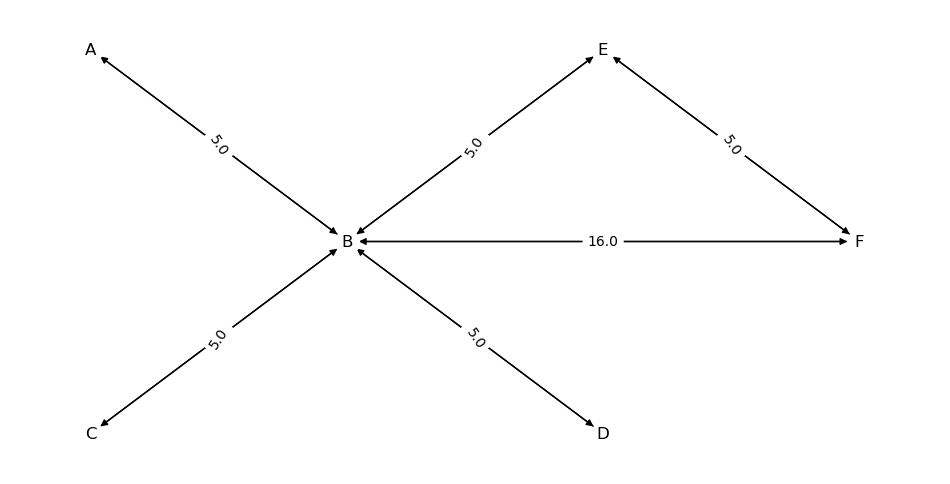

In [2]:
# Create graph
example_graph = Graph()

# Add graph edges
example_graph.add_edge("A", "B", weight=5.0)
example_graph.add_edge("B", "C", weight=5.0)
example_graph.add_edge("B", "D", weight=5.0)
example_graph.add_edge("B", "E", weight=5.0)
example_graph.add_edge("E", "F", weight=5.0)
example_graph.add_edge("B", "F", weight=16.0)

# Node locations (for visual representation)
example_node_locations = dict(A= (0,3), B= (4,0),
                              C= (0, -3), D= (8, -3),
                              E= (8, 3), F= (12, 0))
# Set the visual x,y position of the nodes
example_graph.set_node_positions(example_node_locations)

# Draw the graph
example_graph.draw()

### <a name="romania_graph"></a>Create the Romania graph

You will now be creating the graph of the Romania cities that is discussed in the AIMA book.
We give you the connections between the cities (`romania_connections`) and the x,y position of each citiy (`romania_locations`).

You graph should look like the following:

<img src=romania.png>

<div class="alert alert-info">
Create the graph in the variable `romania_graph`
</div>

In [3]:
# (don't modify this cell -- it will be overwritten by our test grading code)
# Distances between Romania's cities
# Example: The distance between C and R (or R and C) is romania_connections['C']['R'] = 146
romania_connections = dict(
    A=dict(Z=75, S=140, T=118),
    B=dict(U=85, P=101, G=90, F=211),
    C=dict(D=120, R=146, P=138),
    D=dict(M=75),
    E=dict(H=86),
    F=dict(S=99),
    H=dict(U=98),
    I=dict(V=92, N=87),
    L=dict(T=111, M=70),
    O=dict(Z=71, S=151),
    P=dict(R=97),
    R=dict(S=80),
    U=dict(V=142))

# x,y positions of Romania's cities
romania_locations = dict(
    A=( 91, 492),    B=(400, 327),    C=(253, 288),   D=(165, 299),
    E=(562, 293),    F=(305, 449),    G=(375, 270),   H=(534, 350),
    I=(473, 506),    L=(165, 379),    M=(168, 339),   N=(406, 537),
    O=(131, 571),    P=(320, 368),    R=(233, 410),   S=(207, 457),
    T=( 94, 410),    U=(456, 350),    V=(509, 444),   Z=(108, 531))

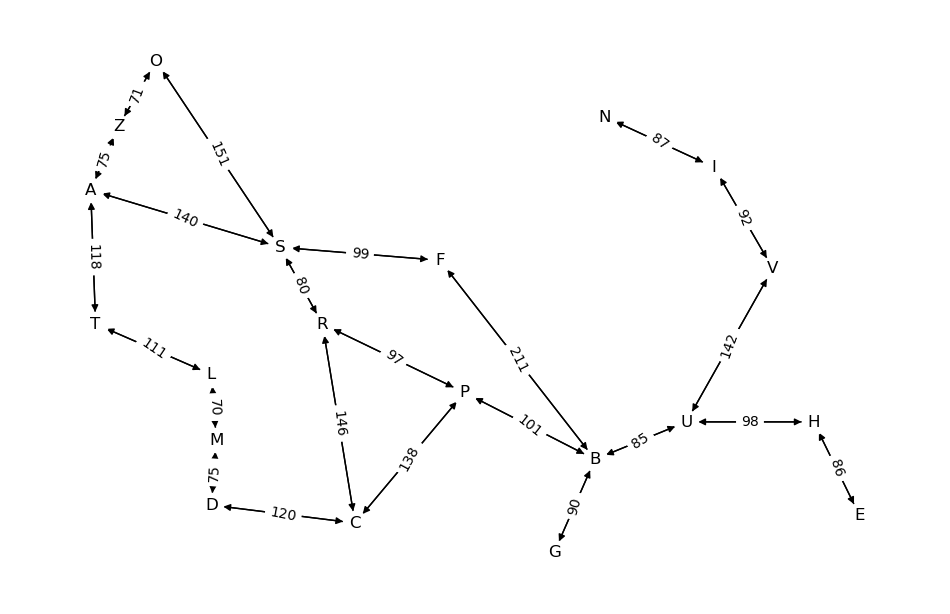

In [16]:
# Write the code to generate the romania_graph in this cell
# Save the graph in the romania_graph variable

romania_graph = Graph()
## Complete the code to generate the graph below...
# YOUR CODE HERE

for first_node in romania_connections.keys():
    for second_node in romania_connections[first_node].keys():
        weight = romania_connections[first_node][second_node]
        romania_graph.add_edge(first_node, second_node, weight)

# Set the visual x,y position of the nodes
romania_graph.set_node_positions(romania_locations)

# Let's draw the graph you have generated now.
romania_graph.draw()

In [17]:
"""Check that the romania graph is correct"""
from nose.tools import assert_equal, ok_
assert_equal(len(romania_graph._nodes), len(romania_locations), "Missing or having extra nodes.")
for node in romania_locations:
    ok_(node in romania_graph._nodes, "All nodes should be in Romania's graph!")
    assert_equal(romania_graph.get_node_pos(node), romania_locations[node],"Location of node is incorrect.")
ne = 0
assert_equal(functools.reduce(lambda x,y: x+len(y), romania_graph._edges.values(),0), 46, "Num of edges is incorrect.")
for src, edges in romania_connections.items():
    for target,weight in edges.items():
        ok_(Edge(src,target,weight) in functools.reduce(lambda a,b: a + list(b), romania_graph._edges.values(), []),
           "Missing or wrong edge.")

test_ok()

Test passed!!

## Implement Best-First Search

### <a name="graph_search_problem"></a>Complete the class definition for `GraphSearchProblem`

In order to implement best first search, we will start by defining the `GraphSearchProblem` class that we'll use in the rest of this problem set.

Complete the function `expand_node(search_node)`.
This function should return a list of SearchNodes expanded from a graph SearchNode such that:

- The parent of the new search nodes is `search_node`
- The state of the new search nodes is the corresponding state according to the graph
- The cost of the new search nodes is the accumulated cost so far until `search_node` plus the cost from the state of the `search_node` to the new search node.

**Example:**
 One of the returned SearchNodes of `SearchNode("R", cost=12)` would be `SearchNode("S",parent_node=<node instance with state="R">,cost=12 + 80)`
 
<div class="alert alert-warning">
 **NOTE:** You may want to look at the definition of `SearchNode` in `search_classes.py`. Note that the `SearchNode` definition that we use in this ProblemSet is a little more complicated than the one used in ProblemSet01.
</div> 

<div class="alert alert-warning"> 
 You will also want to look at the `graph.py` file. In particular, note that the function `Graph.node_edges(node)` will give you all the outgoing Edges of a node in the graph. Also, each Edge has properties such as: source (the starting node), target (the end node) and weight (cost) of the edge.
</div>

<div class="alert alert-info">
Fill the code below.
</div>

In [18]:
# Complete the definition of expand_node below
class GraphSearchProblem(object):
    def __init__(self, graph, start, goal):
        self.graph = graph
        self.start = start
        self.goal = goal
    def test_goal(self, state):
        return self.goal == state
    def expand_node(self, search_node):
        """Return a list of SearchNodes, having the correct state, parent and updated cost."""
        expanded_sn = []
        edges = self.graph.node_edges(search_node.state)
        current_cost = search_node.cost
        for edge in edges:
            source = edge.source
            target = edge.target
            weight = edge.weight
            expanded_sn.append(SearchNode(target, parent_node=search_node, cost=weight+current_cost, action=None))
        return expanded_sn

In [19]:
"""Check that GraphSearchProblem is implemented correctly"""
from nose.tools import assert_equal, ok_
test_problem = GraphSearchProblem(romania_graph, "A","G")
expanded_sn = test_problem.expand_node(SearchNode("T","A",15))
assert_equal(len(expanded_sn), 2)
ok_(SearchNode("A") in expanded_sn)
ok_(SearchNode("L") in expanded_sn)
ok_(functools.reduce(lambda a,b:a and b._parent==SearchNode("T"),expanded_sn,True),
   "Wrong parent.")
ok_(functools.reduce(lambda a,b:a and b._cost==15+romania_connections[b.state]["T"],expanded_sn,True),
   "Wrong accumulated cost.")
del test_problem, expanded_sn
test_ok()

Test passed!!

### <a name="bfs"></a>Best-First Search algorithm

Now you will finally implement the Best-First Search algorithm with an expanded list.

Complete the code for `best_first_search(problem, f)` that takes a problem (such as `GraphSearchProblem` and a function `f(SearchNode)` and that returns a tuple of the following (in this order):

1. The best path from `problem.start` to `problem.goal` (according to the minimum `f`). Return the path as a `Path` class (see `search_classes.py`). (Note: This is very simple. You only need to return `Path(goal_node)` if `problem.test_goal(goal_node.state) == True`)
2. The number of expanded nodes (the size of the expanded list).
3. The maximum size that the queue reaches.

Note: consider that the signature of `f` is `f(SearchNode) -> value`. That is, `f` takes a SearchNode and returns a number.

**Hints regarding the PriorityQueue and the SearchNode classes:**

- The PriorityQueue will order the elements by the **min** value of `f` of each element.
- Whenever you do `q.pop()`, you get the element with the lowest f. Also, that element is removed from the queue at the same time.
- You can test whether something was already in the queue with the statement: `element in q`. Where `element` is whatever you want to test if it was in the queue.
- To test whether `element` is in the queue, the PriorityQueue iterates through all its elements and returns `True` if there is one element (`elementInQ`) for which `element == elementInQ` returns `True`.
- The `SearchNode` class that we are giving you is defined so that `search_node1 == search_node2` returns `True` if both `search_node1` and `search_node2` have the same state, **even if both have different parents, or different costs!**
- Because of this, you can use `search_node in q` to test if `q` contains a **different search node** (with possible different parent or cost) that has the same state than `search_node`.
- If that is the case, you can retrieve that previous search node that was in q, `previous_search_node`, with the same state as `search_node` by doing:

```python
previous_search_node = q[search_node]
```

- You could now compare any aspects of `previous_search_node` and `search_node` (you know they both have the same state, but the other properties could be different)
- Finally, you can delete that previous search node that was in the queue, and replace it by the search node. The position in the queue will be determined automatically by the `f` function.

```python
# BEFORE: previous_search_node is in q and has state s
del q[previous_search_node]
q.append(search_node)
# AFTER: previous_search_node is no longer in q
# search_node is now in q and has state s
# the actual position of search_node in the q, will
# most likely be different from whatever that of previous_search_node was
```

- You will probably have to do this at some point. (If there's already a path to some state A, and you find a better path to state A, you want to delete that worse path from the Q and add the better path).


<div class="alert alert-info">
Complete the code for `best_first_search` below.
</div>

In [63]:
# We provide stub code for the simple_search function that you must fill.
# The lecture slides will be useful here.
def best_first_search(problem, f):
    """Returns a solution path."""
    q = PriorityQueue(f=f)
    q.append(SearchNode(problem.start))
    expanded = set([problem.start])
    max_q = 1
    path = list()
    while q:
        # YOUR CODE HERE
        search_node = q.pop() #pick node from q with best f
        expanded.add(search_node.state)
        if problem.test_goal(search_node.state): # if node = goal, return
            return (Path(search_node),len(expanded),max_q)
        else:
            children = problem.expand_node(search_node) #find all children
            for next_node in children:
                if next_node.state not in expanded:
                    if next_node in q: #check if next_node already in queue
                        previous_search_node = q[next_node]
                        existing_value = f(previous_search_node)
                        new_value = f(next_node)
                        if existing_value <= new_value:
                            pass
                        else:
                            del q[previous_search_node] #if cost of next_node is less than the already existing, replace in q
                            q.append(next_node)
                    else:
                        q.append(next_node) #add to q each of the next_nodes
        if len(q) > max_q:
            max_q = len(q)
    # If we get to here, no solution has been found.
    return None, len(expanded), max_q

### <a name="ucs"></a>Implement Uniform Cost Search

Implement the function `uniform_cost_search(problem)` that uses the `best_first_search` code you defined earlier together with some definition of a function `f(SearchNode) -> value` that you'll pass to `best_first_search`.
Remember that Uniform Cost Search expand nodes in increasing order of cost. It will be useful to look at the definition of `SearchNode` (in `search_classes.py`), to see what information you can use.

<div class="alert alert-info">
Complete the code for `uniform_cost_search` below.
</div>

In [56]:
def uniform_cost_search(problem):
    # YOUR CODE HERE
    def f(node):
        return node.cost
    return best_first_search(problem,f)

UniformCostSearch Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 15. Max size of the queue: 4


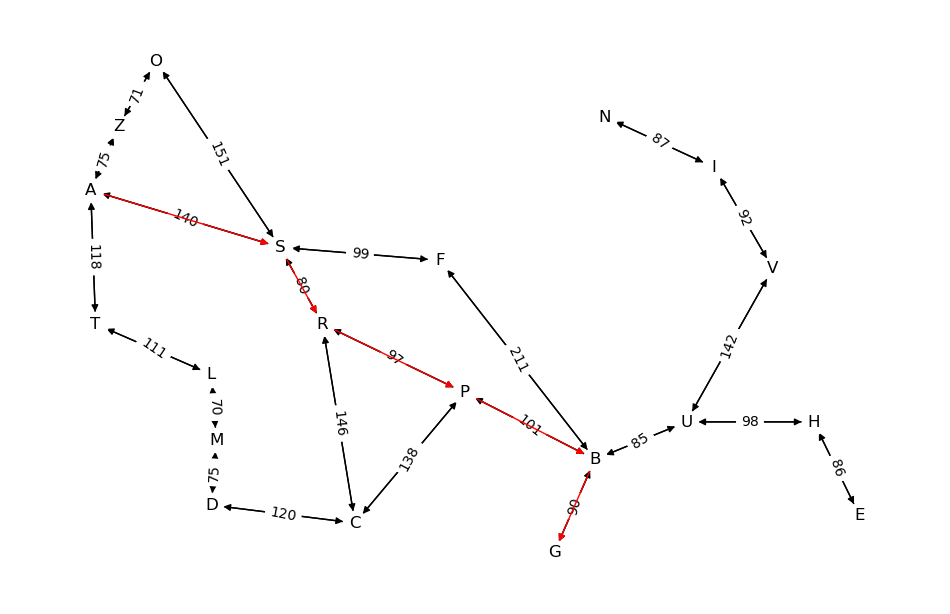

In [65]:
"""Try your implementation of Uniform Cost Search with this code"""

romania_problem = GraphSearchProblem(romania_graph, "A","G")
path, expanded, maxq = uniform_cost_search(romania_problem)
print("UniformCostSearch Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(path, expanded, maxq))

# Draw solution
if path:
    romania_graph.draw(highlight_edges=list(path.edges()))

In [66]:
"""Test uniform cost search."""
from nose.tools import assert_equal, ok_
test_problem = GraphSearchProblem(romania_graph, "A","G")
result = uniform_cost_search(test_problem)
ok_(isinstance(result,tuple) and len(result) == 3, "Result should be a 3-tuple")
ok_(isinstance(result[0],Path), "The first element should be a Path")
assert_equal(result[0].cost, 508, "Cost should be 508.")
assert_equal(result[0].path, ['A', 'S', 'R', 'P', 'B', 'G'])
assert_equal(result[1],15)
assert_equal(result[2],4)
del test_problem

test_ok()

Test passed!!

### Greedy Search and A*

In order to implement greedy search and A*, we first need to define the heuristic we want to use. Remember that the heuristic is an estimate of the distance from a given state to the goal.

We say that the heuristic is **admissible** if it is optimistic (it never over estimates the distance).

#### <a name="eucl_distance"></a>Heuristics

Given that we know the `(x,y)` position of the cities of Romania (`romania_locations`), we'll use the straight line distance between cities as our heuristic.

Implement the `euclidean_distance(a,b)` function that returns the straight line distance between a and b. Consider that a and b are given as 2D tuples (e.g. `a=(0,0)`, `b=(3,4)`, then `euclidean_distance(a,b)=5`).

$distance = \sqrt{(a_x-b_x)^2 + (a_y - b_y)^2}$

<div class="alert alert-info">
Complete the code for `eucl_distance` below.
</div>


In [67]:
def eucl_dist(a, b):
    """Returns the euclidean distance between a and b."""
    # YOUR CODE HERE
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
    

In [68]:
"""Test euclidean distance code."""
from nose.tools import assert_almost_equal
assert_almost_equal(eucl_dist((-12,47), (10, -5)), 56.46237685)
test_ok()

Test passed!!

Now let's define a specific euclidean distance heuristic from any SearchNode to the "G" state.
You will probably want to use the `romania_locations` dictionary.

**Example:** `h_to_G(SearchNode("A"))` should return about `360.4719`

<a name="h_to_g"></a>
<div class="alert alert-info">
Complete the code for `h_to_G` below.
</div>

In [69]:
goal_state = "G"
def h_to_G(search_node):
    # YOUR CODE HERE
    a = romania_locations[search_node.state]
    b = romania_locations[goal_state]
    return eucl_dist(a,b)
    

In [70]:
"""Test h_to_G."""
from nose.tools import assert_equal, ok_, assert_almost_equal
assert_almost_equal(h_to_G(SearchNode("A")),360.471912914)
assert_almost_equal(h_to_G(SearchNode("Z")),373.376485601)
assert_almost_equal(h_to_G(SearchNode("H")),177.991572834)
assert_equal(h_to_G(SearchNode("G")), 0.0)
test_ok()

Test passed!!

#### <a name="greedy_search"></a>Implement Greedy Search

Implement `greedy_search(problem,h)`. Assume that `h(SearchNode)` is a function that returns the heuristic of a search node with respect to some goal.

Use the `best_first_search` function.

<div class="alert alert-info">
Complete the code for `greedy_search` below.
</div>

In [71]:
def greedy_search(problem, h):
    # YOUR CODE HERE
    return best_first_search(problem,h)
    

Greedy Path:
 Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G']. 
Nodes expanded: 5. Max size of the queue: 7


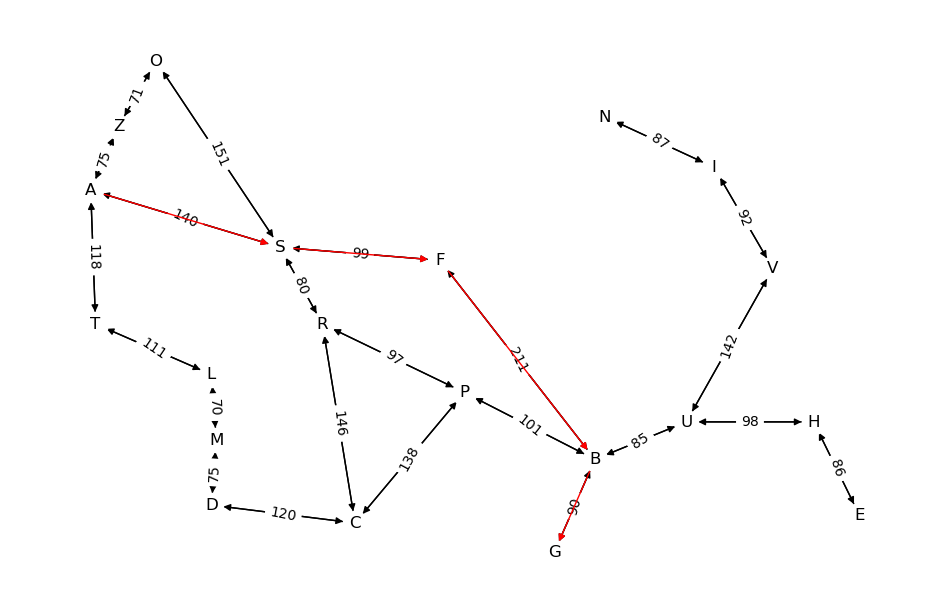

In [72]:
"""Try your greedy search implementation with this code"""
start_state = "A"

romania_problem = GraphSearchProblem(romania_graph, start_state,goal_state)
path, expanded, maxq = greedy_search(romania_problem, h_to_G)
print("Greedy Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(path, expanded, maxq))

# Draw solution
if path:
    romania_graph.draw(highlight_edges=list(path.edges()))

#### <a name="astar"></a>Implement A* Search

Implement `astar_search(problem,h)`. Assume that `h(SearchNode)` is a function that returns the heuristic of a search node with respect to some goal.

Use the `best_first_search` function.

Remember that for A*, $f(n) = cost(n) + h(n)$.

<div class="alert alert-info">
Complete the code for `astar_search` below.
</div>

In [73]:
def astar_search(problem, h):
    # YOUR CODE HERE
    def astar(node,h=h):
        return node.cost+h(node)
    return best_first_search(problem,astar)
    

A* Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 11. Max size of the queue: 6


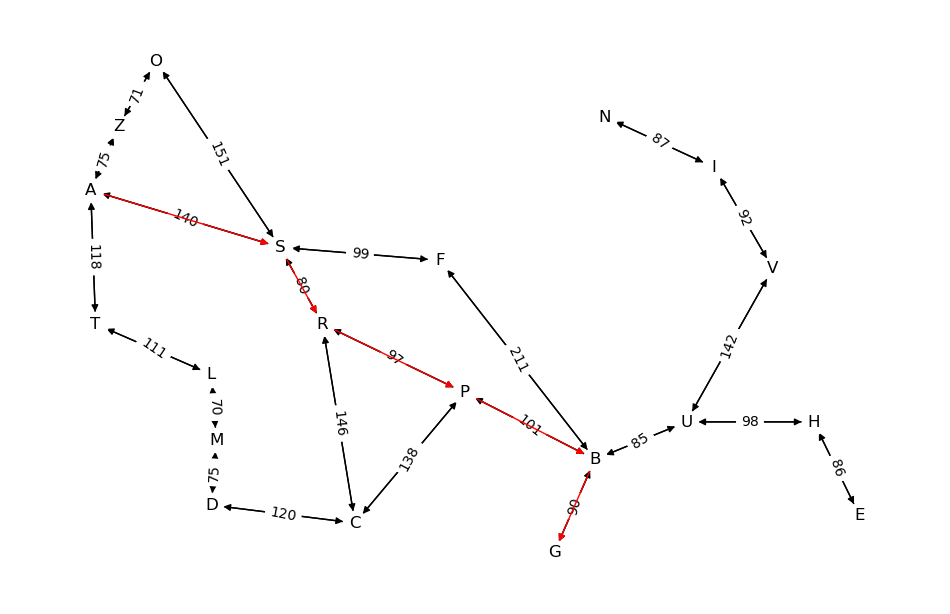

In [74]:
"""Try your A* search implementation with this code"""
start_state = "A"

romania_problem = GraphSearchProblem(romania_graph, start_state,goal_state)
path, expanded, maxq = astar_search(romania_problem, h_to_G)
print("A* Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(path, expanded, maxq))

# Draw solution
if path:
    romania_graph.draw(highlight_edges=list(path.edges()))

In [75]:
"""Test A* search."""
from nose.tools import assert_equal, ok_
test_problem = GraphSearchProblem(romania_graph, "A","G")
result = astar_search(test_problem, h_to_G)
assert_equal(result[0].cost, 508, "Cost should be 508.")
assert_equal(result[0].path, ['A', 'S', 'R', 'P', 'B', 'G'])
# assert_equal(result[1],11)
# assert_equal(result[2],6)
del test_problem, result

test_ok()

Test passed!!

In [76]:
"""Compare the results of uniform cost search, greedy search and A*"""

problem = GraphSearchProblem(romania_graph, "A", "G")

sol, expanded, maxq = uniform_cost_search(problem)
print("UCS Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(sol, expanded, maxq))

sol, expanded, maxq = greedy_search(problem, h_to_G)
print("Greedy Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(sol, expanded, maxq))

sol, expanded, maxq = astar_search(problem, h_to_G)
print("A* Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(sol, expanded, maxq))


UCS Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 15. Max size of the queue: 4
Greedy Path:
 Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G']. 
Nodes expanded: 5. Max size of the queue: 7
A* Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 11. Max size of the queue: 6


## <a name="grid_search"></a>Path Planning on a Grid

In this section you'll learn how to do path planning on a grid.

<img src="grid_path.png"/>

### Getting familiarized with the Grid class

We have provided a `Grid` class.
The following code shows how to use the Grid class. The `Grid` class is defined in `grid.py`.

Note that the origin of the grid `(0,0)` corresponds to the lower left cell, and that `x` increases to the right, and `y` increases going up.

Num cols, num rows:  (6, 6)
(2,1) is obstacle? True
(0,0) is obstacle? False
Cell dimensions:  (1.0, 1.0)


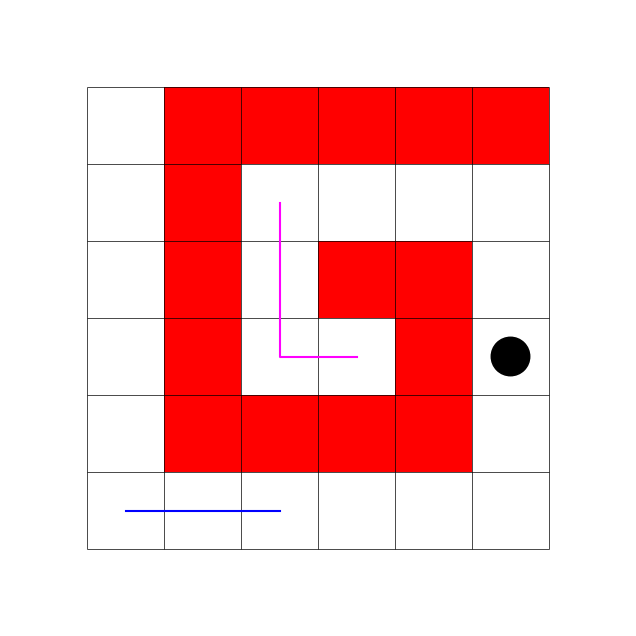

In [120]:
# Create grid from text.
# 1: obstacle, 0: free region
# Modify the text to create your own grid
# Ensure that the number of columns is constant!
grid_str = """0 1 1 1 1 1
              0 1 0 0 0 0
              0 1 0 1 1 0
              0 1 0 0 1 0
              0 1 1 1 1 0
              0 0 0 0 0 0"""
test_grid = Grid.create_from_str(grid_str)

# Access the grid elements
print("Num cols, num rows: ", test_grid.size)
print("(2,1) is obstacle?", test_grid.grid_array[2,1] > 0)
print("(0,0) is obstacle?", test_grid.grid_array[0,0] > 0)
print("Cell dimensions: ", test_grid.cell_dimensions)

# Drawing functions
# Draw the grid
axes = test_grid.draw()
# Draw a circle in cell (5,2) [col 5, row 2]
test_grid.draw_cell_circle(axes, (5,2),color='black')
# You can draw some paths, too
test_grid.draw_path(axes, [(0,0), (1,0), (2,0)], color='blue')
test_grid.draw_path(axes, [(2,4), (2,3), (2,2), (3,2)], color='magenta')

### <a name="grid_to_graph"></a>Creating a graph from a grid

You will code the function `grid_to_graph(grid, diagonal_moves)` that creates a `Graph` class like the one we have been using in the rest of the exercise from a `Grid`.

Keep the following things in mind when coding this function:

- The number of nodes in the graph needs to be equal to the number of obstacle free cells in the grid. (i.e. don't create nodes for cells that are blocked)
- The nodes should be designed by a tuple of their (col, row) position, being the lower left cell the (0,0) node, and the upper right cell the (num_cols-1, num_rows-1) cell. That, is, to create nodes (2,3) and (2,4) and add an edge of length 5.0 between them, you should do: `graph.add_edge((2,3),(2,4), 5.0)`. If cell `(2,3)` is obstacle free, then `"(2,3) in graph"` should return `True`.
- Use the right length for the edges. `grid.cell_dimensions` gives you the `(width, height)` of each cell. Keep in mind that diagonal moves are longer than straight moves.
- Note that `graph.add_edge((2,3),(2,4), 5.0)` creates an edge from (2,3) to (2,4) but ALSO, from (2,4) to (2,3). It doesn't matter the order that you choose, and it's ok if you do it multiple times (the graph will only keep one edge).
- A grid cell can connect to any other adjacent one if both cells are obstacle free.
- Only connect cells diagonally if the argument `diagonal_moves = True`.


<div class="alert alert-info">
Complete the code for `grid_to_graph` below.
</div>

In [118]:
def grid_to_graph(grid, diagonal_moves=True):
    graph = Graph()
    (width,height) = grid.cell_dimensions
    (num_cols,num_rows) = grid.size
    node_locations = dict()
    for x in range(num_cols):
        for y in range(num_rows):
            if grid.grid_array[x,y] == 0: #if cell is obstacle free
                graph.add_node((x,y))
                node_locations[(x,y)] = grid.cell_xy(x,y) #add node location
                if x+1 < num_cols and grid.grid_array[x+1,y] == 0:
                    graph.add_edge((x,y),(x+1,y),width)
                    
                if grid.grid_array[x-1,y] == 0 and x-1 >= 0:
                    graph.add_edge((x,y),(x-1,y),width)
                    
                if grid.grid_array[x,y-1] == 0 and y-1 >= 0:
                    graph.add_edge((x,y),(x,y-1),height)
                    
                if y+1 < num_rows and grid.grid_array[x,y+1] == 0:
                    graph.add_edge((x,y),(x,y+1),height)
                    
                if diagonal_moves:
                    diag = math.sqrt(width**2+height**2)
                    try:
                        if grid.grid_array[x+1,y+1] == 0:
                            graph.add_edge((x,y),(x+1,y+1),diag)
                    except Exception: pass
                    try:
                        if grid.grid_array[x+1,y-1] == 0 and y-1 >= 0:
                            graph.add_edge((x,y),(x+1,y-1),diag)
                    except Exception: pass
                    try:
                        if grid.grid_array[x-1,y+1] == 0 and x-1 >= 0:
                            graph.add_edge((x,y),(x-1,y+1),diag)
                    except Exception: pass
                    try:
                        if grid.grid_array[x-1,y-1] == 0 and x-1 >= 0 and y-1 >= 0:
                            graph.add_edge((x,y),(x-1,y-1),diag)
                    except Exception: pass

    # Set the visual x,y position of the nodes
    graph.set_node_positions(node_locations)
    return graph

In [119]:
"""Test grid to graph function. Don't modify the grid test string or the tests will fail."""
from nose.tools import assert_equal, ok_
grid_test_str = """0 1 0 1
                   0 0 0 1
                   1 0 0 1
                   0 1 1 0"""
test_grid = Grid.create_from_str(grid_test_str)
num_cols, num_rows = test_grid.size
test_graph = grid_to_graph(test_grid, diagonal_moves=False)

# Test states
num_grid_states = np.prod(test_grid.size) - len(test_grid.get_obstacles())
assert_equal(len(test_graph._nodes), num_grid_states)
for x,y in [(x, y) for x in range(num_cols) for y in range(num_rows)]:
    ok_(((x,y) in test_graph) == (test_grid.grid_array[x,y]==0),
        "({0},{1}) should be in the graph and it's not, or viceversa".format(x,y))
hori_length, vert_length = test_grid.cell_dimensions
diag_length = math.sqrt(hori_length**2 + vert_length**2)
# Check edges - no diagonal
num_edges = functools.reduce(lambda a,b: a+len(b), test_graph._edges.values(),0)
assert_equal(num_edges, 14)
ok_(Edge((1,1),(2,1),hori_length) in test_graph.node_edges((1,1)))
ok_(Edge((1,1),(1,2),vert_length) in test_graph.node_edges((1,1)))
ok_(Edge((0,0),(1,1),diag_length) not in test_graph.node_edges((0,0)))
# Check edges - diagonal moves
test_graph = grid_to_graph(test_grid, diagonal_moves=True)
num_edges = functools.reduce(lambda a,b: a+len(b), test_graph._edges.values(),0)
assert_equal(num_edges, 28)
ok_(Edge((1,1),(2,1),hori_length) in test_graph.node_edges((1,1)))
ok_(Edge((1,1),(1,2),vert_length) in test_graph.node_edges((1,1)))
ok_(Edge((0,0),(1,1),diag_length) in test_graph.node_edges((0,0)))

test_ok()

Test passed!!

### Path planning on a grid

Now we'll use the graph we have created to do path planning on the grid with the search algorithms you have coded earlier.

#### <a name="eucl_dist_cell"></a>Euclidian distance between grid cells

Let's start defining the function `eucl_dist_cell(graph_node, goal_cell, cell_dimensions)`.
This function represents the euclidean distance between two cells (taking into account the width and the height of each cell).

As an example, the result of `eucl_dist_cell(SearchNode((2,3)), (5,5), (1,2))` should be `5.0`. This represents the distance between cell `(2,3)` and cell `(5,5)` if the width of each cell is `1` and the height of each cell is `2`.

<div class="alert alert-info">
Complete the code for `eucl_dist_cell` below.
</div>


In [123]:
def eucl_dist_cell(graph_node, goal_cell, cell_dimensions):
    # YOUR CODE HERE
    (width,height) = cell_dimensions
    xidiff = abs(graph_node.state[0] - goal_cell[0])
    yidiff = abs(graph_node.state[1] - goal_cell[1])
    return math.sqrt((xidiff*width)**2 + (yidiff*height)**2)
    

In [124]:
"""Test the eucl_dist_cell function"""
from nose.tools import assert_almost_equal
assert_almost_equal(eucl_dist_cell(SearchNode((2,3)), (5,5), (1,2)), 5.0)
assert_almost_equal(eucl_dist_cell(SearchNode((8,2)), (4,2), (2,3)), 8.0)
assert_almost_equal(eucl_dist_cell(SearchNode((3,4)), (3,4), (2,3)), 0.0)
test_ok()

Test passed!!

Now let's use the your definition of `eucl_dist_cell` to create the heuristic function and use A\* to find a path in the grid.

Run the code below. You should see how A\* finds the path in the grid. Try changing the `diagonal_moves` option in the `grid_to_graph` function to see how that affect the paths that you get.

A* Path:
 Path of length 13, cost: 12.000: [(2, 1), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (4, 3)]. 
Nodes expanded: 16. Max size of the queue: 2


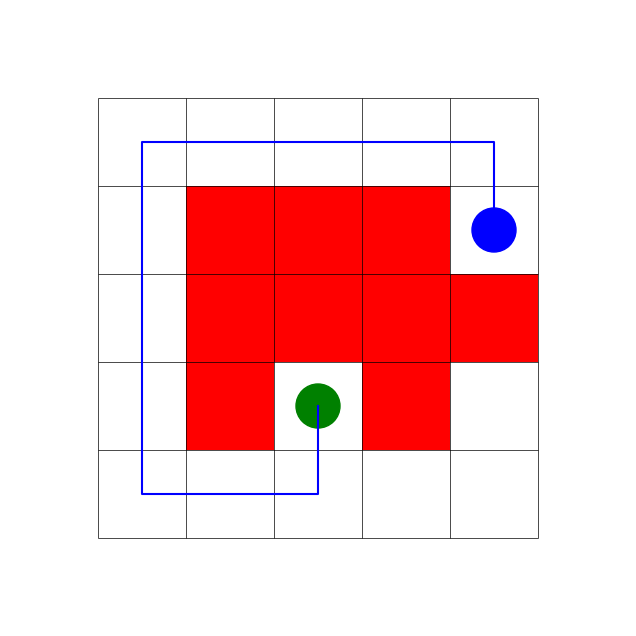

In [126]:
"""Try your A* implementation with this code."""

start = (2,1)
goal = (4,3)

grid_str = """0 0 0 0 0
              0 1 1 1 0
              0 1 1 1 1
              0 1 0 1 0
              0 0 0 0 0"""
grid = Grid.create_from_str(grid_str)

# Define the heuristic function that returns the heuristic distance from any search node to
# the goal cell
h = lambda n: eucl_dist_cell(n, goal, grid.cell_dimensions)

graph = grid_to_graph(grid, diagonal_moves=False)

problem = GraphSearchProblem(graph, start,goal)

solution_astar, expanded, maxq = astar_search(problem, h)
print("A* Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(solution_astar, expanded, maxq))

# Plot
axes = grid.draw()
grid.draw_path(axes,solution_astar.path, color='b')
grid.draw_cell_circle(axes, start, color='g')
grid.draw_cell_circle(axes, goal, color='b')

#### <a name="astar_grid_test"></a>Test A\* in a grid

Let's test that your A\* implementation is correct.

In [127]:
"""Test A* in a grid. Don't modify the grid test string or the tests will fail."""
from nose.tools import assert_equal, ok_
start, goal = (2,1), (4,3)
grid_str = """0 0 0 0 0
              0 1 1 1 0
              0 1 1 1 1
              0 1 0 1 0
              0 0 0 0 0"""
grid = Grid.create_from_str(grid_str)
h = lambda n: eucl_dist_cell(n, goal, grid.cell_dimensions)
graph = grid_to_graph(grid, diagonal_moves=True)
problem = GraphSearchProblem(graph, start,goal)
solution_astar, expanded, maxq = astar_search(problem, h)
assert_equal(solution_astar.path, [(2, 1), (1, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 3)])
assert_almost_equal(solution_astar.cost, 9.65685424949238)
test_ok()

Test passed!!

#### <a name="greedy_worse_paths"></a>Find instances in which greedy search produces worse paths than A\*

Try running A\* and Greedy Search in the graph below.

<div class="alert alert-info">
Find start and goal locations for which the solution returned by Greedy Search is much worse than A*.
</div>

In [150]:
# Modify the start and goal locations
# Example (not a good choice)
# Uncomment to test
start, goal = (0,20),(39,20)
# YOUR CODE HERE


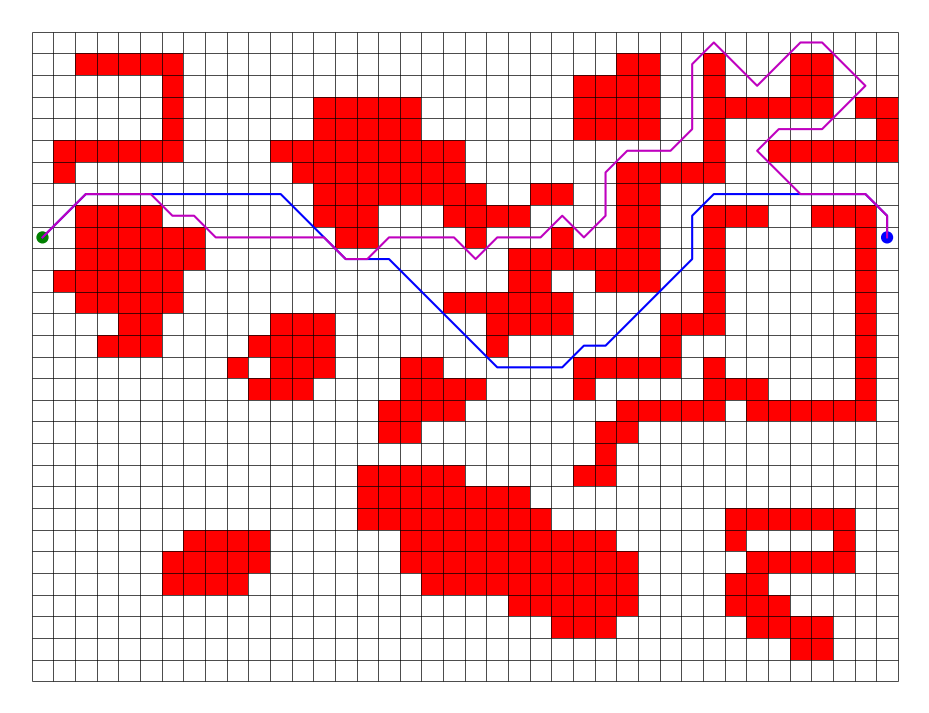

In [151]:
"""Try your chosen start and goal locations with this code."""
grid = Grid.create_from_file("grids/hard.txt")
h = lambda n: eucl_dist_cell(n, goal, grid.cell_dimensions)
graph = grid_to_graph(grid, diagonal_moves=True)
problem = GraphSearchProblem(graph, start,goal)
solution_astar, expanded, maxq = astar_search(problem, h)
solution_greedy, expanded, maxq = greedy_search(problem, h)

# Draw
axes = grid.draw()
grid.draw_path(axes,solution_astar.path, color='b')
grid.draw_path(axes,solution_greedy.path, color='m')
grid.draw_cell_circle(axes, start, color='g')
grid.draw_cell_circle(axes, goal, color='b')

#### <a name="greedy_explanation"></a>Explain why the path returned by Greedy search is worse (5 points)

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Greedy search only looks forward, so if a suboptimal path is optimal for the first part of the path, greedy will proceed down that suboptimal path.

## <a name="complexity"></a> Complexity Analysis

In this problem, you will develop skill at performing a time and space complexity analysis of uninformed search.  
Consider the following directed graph:

![title](complexity.png)

Assume that we are performing an uninformed search starting from vertex 0 and our goal is vertex 2N+2. Search terminates when the goal has been examined (i.e. landed on, “expanded”, reached the front of the queue). 

Whenever faced with two paths, the vertex with the lower index is examined first.

*Hint: Note the direction of the arrow entering the goal vertex. This direction implies that N will always be an even number.  This should help when determining your analytical expressions.  Assume that N  >= 2*




## Include typed or handwritten work for this problem:

This problem on complexity is not about coding Python. Instead, you are asked to derive and present analytical expressions. 

**Showing how you reached the final expressions is required.**

The two options for submitting your solutions, and the work that supports them, are to type up your work in the cells provided below or upload images of handwritten work into the cells.
        
To add handwritten work:<br>
    1. Ensure that your work is legible and solutions are clearly marked* <br>
    2. Capture an image of your work <br>
    3. Upload the file to the folder that this notebook is in <br>
    4. Double-click on the one of the solution cells below and add the following:
    
    ![title](example_upload.jpg)
    
    4. Pasting this line into the cell will result in an example image being displayed. (After executing the cell)
    Update the filler name to match your uploaded handwritten work.

*or add an additional Markdown cell below your image where you type the solutions

### <a name="dfs_v"></a>Depth-first Search with Visited List

Derive a precise analytical expression (in terms of N) for the **number of vertices that depth first search examines** (i.e. landed on, “expanded”, reached the front of the queue) to arrive at the goal. Include the start vertex and of course, the goal vertex.  Assume that depth first search uses a visited list.  Note that there is a distinction between the vertices examined and the partial paths that are merely placed on the queue.  

Then derive an analytical expression for the largest number of partial paths that will be on the queue at one instance (maximum queue size) before reaching the goal. 

Note that these are the time and space requirements, respectively. 

<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

Assuming the algorithm stops once the goal is reached (even if it not the optimal path):

2N+2 will always be even, thus the search will always end on the right side.

The first path will go straight down from 0, 1, 3, all the way to 2N+1. The number of vertices from node 1 to node 2N+1 is ((2N+1)-1)/2 = N, and one vertex from 0 to 1, so this first path requires examining N+1 vertices. The next path would go from 0, 1, 3, all the way to 2N-1 and finally 2N+2. Going from node 1 to 2N-1, DFS examines ((2N-1)-1)/2 = N-1, add one vertex going from node 0 to 1 sums to N vertices. In total, DFS will examine N+N+1 = 2N+1 vertices.

The number of vertices extending from node 0 is two, then each node that vertex connects to has one node extending from it. The pattern repeats, every other node having 2, then 1 vertices extending from it. Every other node visited adds one path in the queue that is unvisited, starting from the path going from 0 to 2, all the way to the path going from 2N-1 to 2N+2. Going down the first path, DFS adds a path to the queue at node 3, 7, 11, to 2N-1 i.e. every other node down the straight path down. Thus, ((2N-1)-3)/4 = (N/2)-1 plus 1 for the path from 0 to 2 summing to a maximum queue size of N/2.

### <a name="bfs_v"></a>Breadth-first Search with Visited List

Repeat these two derivations for breadth first search.  Assume that a visited list has been used.

<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

(0,1) (0,2) {0,1,2}
(0,1,3) (0,2,4) {0,1,2,3,4}
(0,1,3,5) (0,1,3,6) (0,2,4,6) {0,1,2,3,4,5,6}
(0,1,3,5,7) (0,1,3,6,8) (0,2,4,6,8) {0,1,2,3,4,5,6,7,8}
(0,1,3,5,7,9) (0,1,3,5,7,10) (0,2,4,6,8,10) {0,1,2,3,4,5,6,7,8,9,10}
The tuple shows the paths in the queue at different levels, appearing in chronological order, and the set shows the visited list at the corresponding point in the search. As can be seen, the maximum number of paths in the queue possible is 3, since out of the two vertices extending from every other even node extends to a node in the visited list. Starting from the sixth vertex examined, every third vertex examined increases the largest node visited by 2. To get to node 2N+2 from node 6 takes ((2N+2)-6)* 3/2 vertices examined. There are 6 vertices examined to get to node 6, so a total of 3N vertices are examined.

### <a name="bfs"></a>Breadth-first Search without Visited List

Repeat the two derivations for a breadth first search that does not use a visited list.

(This one is a bit challenging. Try your best to develop a precise expression). 

<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

(0,1) (0,2) #2
(0,1,3) (0,2,4) #2
(0,1,3,5) (0,1,3,6) (0,2,4,1) (0,2,4,6) #4
(0,1,3,5,7) (0,1,3,6,8) (0,2,4,1,3) (0,2,4,6,8) #4
(0,1,3,5,7,9) (0,1,3,5,7,10) (0,1,3,6,8,5) (0,1,3,6,8,10) (0,2,4,1,3,5) (0,2,4,1,3,6) (0,2,4,6,8,5) (0,2,4,6,8,10) #8

The tuple shows the paths in the queue at different points in the search, appearing in chronological order, and the number after the hashtag is the number of paths in the queue at that point. The removal of the visted list causes the queue to double as the maximum node reached increases by 4, starting from queue length of 2 at max node 2. To get to node 2N+2 from node 2, the maximum queue length reaches 2 * ((2N+2)-2)* 2/4 = 2N. However, since the 2N+2 node will be found before the last child in the level is reached (specifically the second child examined) so, the maximum queue length will actually be the previous step, 2N/2 = N, plus 1, to a total of N+1 being the maximum queue size reached. The number of vertices examined is equal to the number of elements in the queue at each interval. Thus, to get from node 4 to node 2N-1, 2*2 + 2*4 + 2*8 +...+2*2N verticies are examined, and 4 vertices are examined to get from node 0 to node 4, so using the sum formula, the total number of vertices examined is 4((1-2^N)/(1-2))+4 = 2^(2+N).